In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [14]:
# ---== wave vector generation ==--- #

# I have made multiple versions to generate the wave vectors for testing
# The deprecated ones are not to be used. Note also we always assume the domain is [0, 1]^2

def generate_k_vectors(K, num_per_dim=10):
    """
    Generate wavevectors with |k| < kmax
    on a uniform 2D grid using fftfreq
    """
    max_threshhold = 1.2*K**2
    min_threshhold = np.pi**2

    kx = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi
    ky = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    k_flat = np.stack((kx.ravel(), ky.ravel()), axis=0)
    
    # Apply radial cutoff
    mag_k = np.sum(k_flat*k_flat, axis=0)
    mask = (mag_k > min_threshhold) & (mag_k < max_threshhold)
    return k_flat[:, mask]  # shape: (2, nk)


def grid_k_vectors(K, max_n=20):
    """
    Generate wavevectors with |k| < kmax
    on a uniform 2D grid with rejection sampling
    """
    max_threshhold = 1.2*K**2
    min_threshhold = np.pi**2

    k_list = []
    for nx in range(-max_n, max_n+1, 2):
        for ny in range(-max_n, max_n+1, 2):
            if nx == 0 and ny == 0:
                continue
            k = 2 * np.pi * np.array([nx, ny])
            mag = np.sum(k*k)
            if  mag > min_threshhold and mag < max_threshhold:
                k_list.append(k)
    return np.array(k_list).T # shape : (2, nk)

# (!) deprecated
def generate_unit_circle_vectors(num_points):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = np.cos(theta)
    y = np.sin(theta)
    points = np.stack([x, y], axis=-1)
    return points

# (!) deprecated
def generate_k_unit_even(num_points):
    theta = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    x = np.cos(theta)
    y = np.sin(theta)
    points = np.stack([x, y], axis=-1)
    return points

# (!) deprecated
def generate_scaled_unit_even(K, num_points):
    kN = num_points//25
    kkkk = generate_k_unit_even(kN)

    max_threshhold = np.sqrt(1.2)*K
    min_threshhold = np.pi    

    km = np.linspace(min_threshhold, max_threshhold, kN*25)

    # Reshape and multiply
    kkkk_expanded = kkkk[:, :, np.newaxis] 
    km_expanded = km[np.newaxis, np.newaxis, :]

    k = kkkk_expanded * km_expanded

    return k.reshape(2, -1)

In [15]:
# ---== inital point pattern generation ==--- #

# Important: the domain is always [0, 1]^2

def random_point_pattern(N):
    return np.random.uniform(0, 1, size=(N, 2)) # shape : (rN, 2)

# ------
# the following methods generate approximately N points and exactly N points if N = k^2, for some k

def uniform_point_pattern(N):
    rN = round(np.sqrt(N))
    space = np.linspace(0.01, .99, rN)
    return np.array(np.meshgrid(space, space)).reshape(2, -1).T # shape : (rN, 2)

def perturbed_point_pattern(N, eps=0.005):
    uniform = uniform_point_pattern(N)
    rN = uniform.shape[0]
    pert_x = eps*np.random.uniform(-1, 1, size=(rN,))
    pert_y = eps*np.random.uniform(-1, 1, size=(rN,))
    uniform[:, 0] += pert_x
    uniform[:, 1] += pert_y
    return uniform  # shape : (rN, 2)

In [16]:
# ---== functions ==--- #

def compute_rho(k, r):
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    exp_ikr = np.exp(1j * k_dot_r)
    return exp_ikr, np.sum(exp_ikr, axis=0)  # (M,)

# for optimization purposes
def compute_S_rho(rho, N):
    return np.abs(rho)**2 / N

def compute_S(k, r):
    N = r.shape[0]
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    sum_exp = np.sum(np.exp(1j * k_dot_r), axis=0)  # (M,)
    return np.abs(sum_exp)**2 / N

def compute_S0(k, D, H, alpha, K_cutoff):
    k_magnitude = np.linalg.norm(k, axis=0)  # (M,)
    S0 = np.where(k_magnitude < K_cutoff, D * (1 - H) * (k_magnitude**alpha) + H, 1.0)
    return S0

def compute_dS_dr(k, r, sum_exp, exp_ikr):
    N = r.shape[0]
    dS_dr = np.zeros((N, 2, k.shape[1]), dtype=np.complex128)

    for d in range(2):  # x and y
        dS_dr[:, d, :] = np.real(1j*k[d, np.newaxis, :] * exp_ikr * np.conj(sum_exp[np.newaxis, :])) / N

    return dS_dr

def compute_gradient_F(r, k, S0_k):
    N = r.shape[0]
    exp_ikr, rho = compute_rho(k, r)
    S_kr = compute_S_rho(rho, N)  # (M,)
    dSkr_dr = compute_dS_dr(k, r, rho, exp_ikr)  # (N, 2, M)
    diff = (S_kr - S0_k)  # (M,)
    grad = 2 * np.real(np.sum(dSkr_dr * diff[np.newaxis, np.newaxis, :], axis=2))  # (N, 2)
    return grad

def objective_function(x, k, S0_k):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    r = np.mod(r, 1.0)
    S_kr = compute_S(k, r)
    return np.sum((S_kr - S0_k)**2)

def gradient_function(x, k, S0_k):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    r = np.mod(r, 1.0) 
    grad = compute_gradient_F(r, k, S0_k)
    return grad.flatten()

In [17]:
# ---== Visualization ==--- #

def plot_wave_vectors(k):
    plt.figure(figsize=(6, 6))
    plt.scatter(k[0, :], k[1, :], marker="x", color="green")
    plt.xlabel("$k_x$")
    plt.ylabel("$k_y$")
    plt.title("Wave vectors")
    plt.show()

def plot_particles(r, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(r[:, 0], r[:, 1], c="blue", s=20)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()

def plot_structure_factor(r, k, K_cutoff, S0_k, title):
    S_kr = compute_S(k, r)
    k_magnitude = np.linalg.norm(k, axis=0)
    plt.figure(figsize=(8, 5))
    plt.scatter(k_magnitude/K_cutoff, S_kr, color="red", label="Computed S(k)")
    plt.scatter(k_magnitude/K_cutoff, S0_k, color="green", label="Computed S_0(k)", marker="x")
    plt.xlabel("|k|")
    plt.ylabel("S(k)")
    plt.title(title)
    plt.legend()
    plt.show()

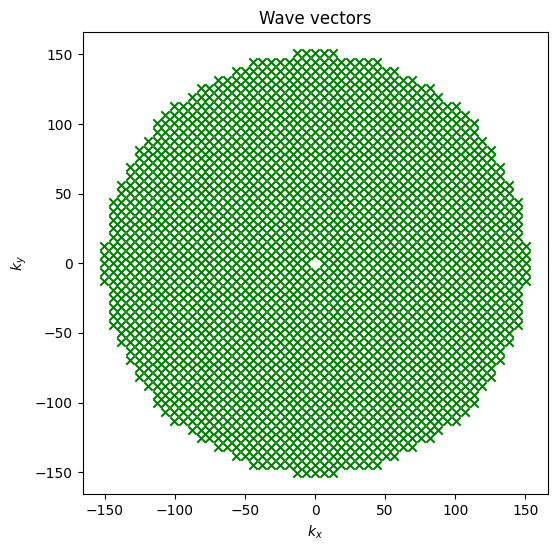

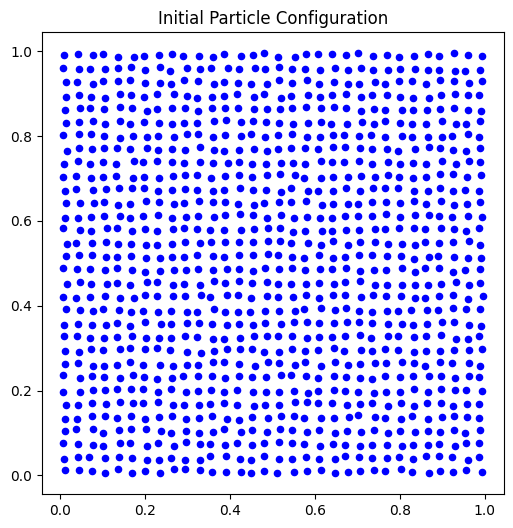

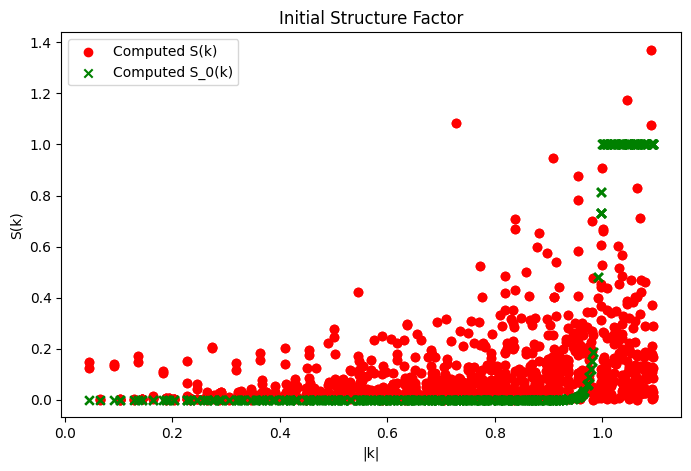

Value before optimizing:  262.8389125315613
         Current function value: 0.000004
         Iterations: 1000
         Function evaluations: 1380
         Gradient evaluations: 1380
  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 4.005711400667485e-06
        x: [ 5.115e-03  2.889e-02 ...  9.941e-01  9.842e-01]
      nit: 1000
      jac: [-4.092e-03 -1.248e-03 ... -2.298e-03 -3.114e-03]
 hess_inv: [[ 4.188e-01  2.931e-02 ...  1.820e-02  1.388e-02]
            [ 2.931e-02  3.999e-01 ... -8.566e-03  3.464e-03]
            ...
            [ 1.820e-02 -8.566e-03 ...  5.531e-01  2.166e-02]
            [ 1.388e-02  3.464e-03 ...  2.166e-02  5.708e-01]]
     nfev: 1380
     njev: 1380
parameters saved to parms.csv
phi saved to point_patterns/pp.npy


c:\Users\eioer\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


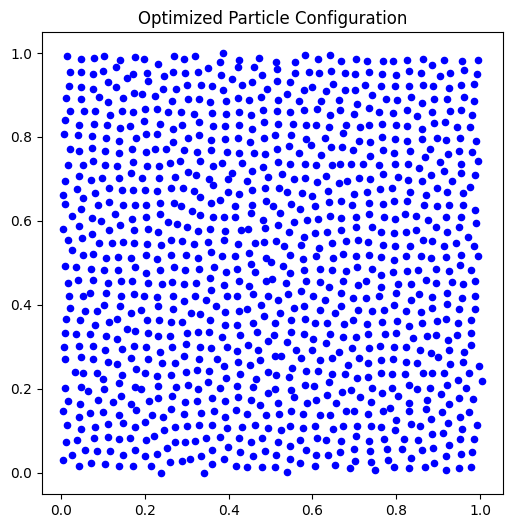

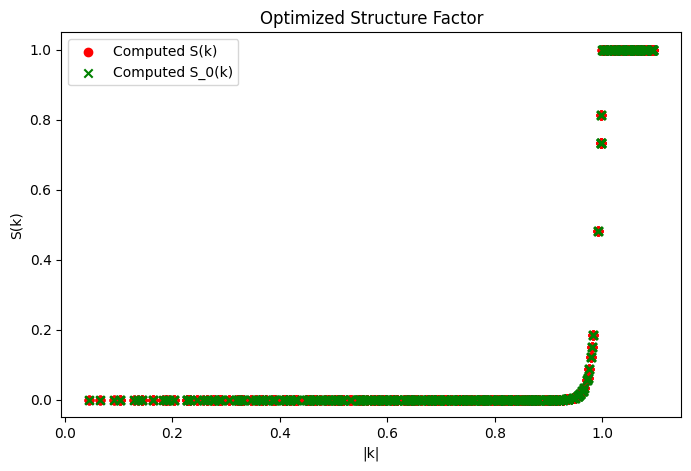

In [18]:
np.random.seed(0)  # For reproducibility

# ---== Parameters ==--- #

N = 1000
M = 100     

# Target structure factor parameters
H = 1e-4
alpha = 100.
K_cutoff = 44*np.pi
D = np.pow(K_cutoff, -alpha)

r_init = perturbed_point_pattern(N)
# since some point pattern generation algos dont give exactly N
N = r_init.shape[0] 

k = generate_k_vectors(K_cutoff,num_per_dim=M)
#k = grid_k_vectors(K_cutoff)
M = k.shape[1]

# Plot wave vectors used:
plot_wave_vectors(k)

# target structure factor precomputation
S0_k = compute_S0(k, D, H, alpha, K_cutoff)

# Plot before optimization
plot_particles(r_init, "Initial Particle Configuration")
plot_structure_factor(r_init, k, K_cutoff, S0_k, "Initial Structure Factor")

print("Value before optimizing: ", objective_function(r_init.flatten(), k, S0_k))

# ---== Run Optimization ==--- #
res = minimize(
    fun=objective_function,
    x0=r_init.flatten(),
    jac=gradient_function,
    args=(k, S0_k),
    method="BFGS",
    options={"disp": True, "maxiter": 1000},
    tol=1e-8
)

# ---== Postprocess ==--- #

r_opt = res.x.reshape(N, 2)  # Final particle positions
print(res)

# Save point pattern:
outfile = f"point_patterns/pp.npy"
np.save(outfile, r_opt)
with open("point_patterns/parms.csv", 'w') as f:
        f.write("N, M, D, H, K_cutoff, alpha\n")
        f.write(f"{N},{M},{D},{H},{K_cutoff},{alpha}\n")
print("parameters saved to parms.csv")
print(f"phi saved to {outfile}")

# Plot after optimization
plot_particles(r_opt, "Optimized Particle Configuration")
plot_structure_factor(r_opt, k, K_cutoff, S0_k, "Optimized Structure Factor")


Minimize:
\begin{equation*}
    F(r) = \Sigma_k |S(k, r) - S_0(k)|^2, r \in \mathbb{R}^N
\end{equation*}
where
\begin{equation*}
    S(k, r) = \frac{1}{N}|\Sigma^N_{j=1} exp(ik*r_j)|^2
\end{equation*}
and $S_0$ is the prescribed structure factor. We may parameterize $S_0(k)$ as 
\begin{equation*}
    S_0(k) = D (1 - H) |k|^\alpha + H, |k|<K; = 1, else
\end{equation*}